In [97]:
import scipy as sc
import seaborn as sb
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]
import warnings
from statistics import mean, median
warnings.filterwarnings('ignore')

In [98]:
sample_size = 500
h = 0.05
window_width = 111  # must be 2k + 1 number

building distribution with trend $$\sqrt{k*h} + N(0,1)$$

In [85]:
norm_d = sc.stats.uniform.rvs(0, 1, sample_size)
my_d = [(k * h)**0.5 + norm_d[k] for k in range(sample_size)]

Moving average method

In [107]:
def moving_avg(sample, window: int):
    """
    :param sample: moving_avg method will extract trend from sample
    :param window: window width
    :return: trend by moving_avg
    """
    gap = int((window - 1) / 2)
    output = [sample[0]]
    for i in range(1, gap):
        output.append(mean(sample[:2*i]))
    for i in range(gap, len(sample) - gap):
        output.append(mean(sample[i-gap:i+gap]))
    for i in range(len(sample) - gap, len(sample)):
        output.append(mean(sample[2*i - 2*len(sample):]))  # negative index

    return output


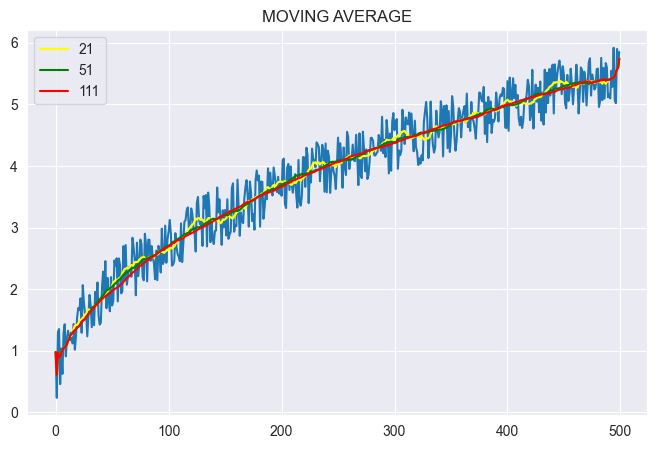

In [108]:
plt.plot(range(sample_size), my_d)
plt.plot(range(sample_size), moving_avg(my_d, 21), 'yellow', label='21')
plt.plot(range(sample_size), moving_avg(my_d, 51), 'green', label='51')
plt.plot(range(sample_size), moving_avg(my_d, 111), 'red', label='111')
plt.title('MOVING AVERAGE')
plt.legend()


Moving median method

In [113]:
def moving_med(sample, window: int):
    """
    :param sample: moving_med method will extract trend from sample
    :param window: window width
    :return: trend by moving_avg
    """
    gap = int((window - 1) / 2)
    output = [median([sample[0], sample[1], 3*sample[1] - 2*sample[2]])]
    for i in range(1, gap):
        output.append(median(sample[:2*i]))
    for i in range(gap, len(sample) - gap):
        output.append(median(sample[i-gap:i+gap]))
    for i in range(len(sample) - gap, len(sample)):
        output.append(median(sample[2*i - 2*len(sample):]))  # negative index

    output[-1] = median([sample[-1], sample[-2], 3*sample[-2] - 2*sample[-3]])
    return output

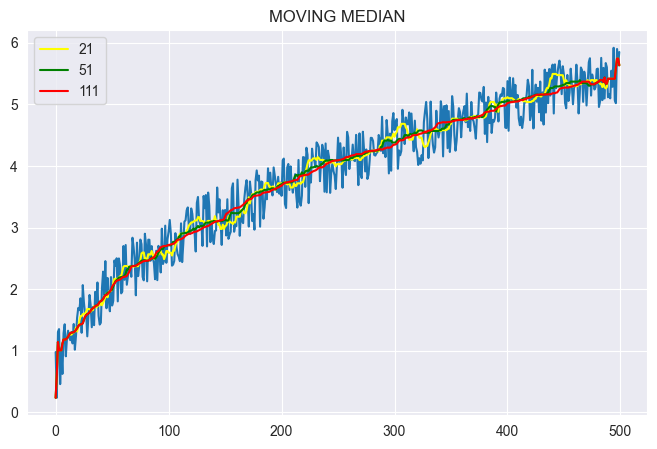

In [114]:
plt.plot(range(sample_size), my_d)
plt.plot(range(sample_size), moving_med(my_d, 21), 'yellow', label='21')
plt.plot(range(sample_size), moving_med(my_d, 51), 'green', label='51')
plt.plot(range(sample_size), moving_med(my_d, 111), 'red', label='111')
plt.title('MOVING MEDIAN')
plt.legend()